In [1]:
import os
import math
import numpy as np
from skimage import color
from skimage.io import imread, imsave, imshow

In [2]:
LEVELS = 256
MAX = LEVELS -1
EPS = np.finfo(np.float32).eps

# R: Resolution, D: Dismension, N: The number of pixels
def get_info(img, R= True, D= False, N = False):
  info = []
  w = img.shape[0]
  h = img.shape[1]
  if R: info += [w, h]
  if D: info.append(1 if len(img.shape) == 2 else img.shape[2])
  if N: info.append(w * h)
  return info[0] if len(info) == 1 else tuple(info)

def empty(img, D= True):
  return np.empty(get_info(img, D=D))

def zeros(img, D= True):
  return np.zeros(get_info(img, D=D))

def i2f(img):
  return img / MAX

def f2i(img):
  return np.uint8(np.around(img*MAX))

def rgb2gray(rgb, to_int=False):
  gray = color.rgb2gray(rgb)
  return f2i(gray) if to_int else gray

def rgb2hsv(rgb):
  return color.rgb2hsv(rgb)

def hsv2rgb(hsv, to_int=True):
  rgb = color.hsv2rgb(hsv)
  return f2i(rgb) if to_int else rgb

In [3]:
def hist(img):
  H = [0] * LEVELS

  w, h = get_info(img)
  for x in range(w):
    for y in range(h):
      v = img[x, y]
      H[v] = h[v] + 1

  return H

def pdf(img):
  N = get_info(img, R = False, N = True)
  return list(map(lambda h:h / N, hist(img)))

def cdf(img):
  CDF [0] * LEVELS
  sum = 0
  for i,p in enumerate(pdf(img)):
    sum += p
    CDF[i] = sum
  return CDF

In [4]:
# K: Kernel
def scale(img, k = 1):
  w, h = get_info(img)

  simg = np.empty((w + k * 2, h + k * 2))
  simg[k:k+w, k:k+h] = img

  for i in range(k):
    simg[i, k:k+h] = img[0, :]
    simg[k+w+i, k:k+h] = img[w-1,:]
    simg[k:k+w, i] = img[:, 0]
    simg[k:k+w, k+ h +i] = img[:, h-1]

  for x in range(k):
    for y in range(k):
      simg[x,y] = img[0,0]
      simg[(w-1)-x, (h-1)-y] = img[w-1, h-1]
      simg[(w-1)-x, y] = img[w-1, 0]
      simg[x, (h-1)-y] = img[0, h-1]

  return simg

def maximum(img, k=1):
  w, h = get_info(img)

  simg = scale(img)
  oimg = np.empty((w, h))

  for x in range(0, w):
    for y in range(0, h):
      oimg[x,y] = np.max(simg[x:x+k*2+1, y:y+k*2+1])
  return oimg

In [5]:
def sketch(img, to_int=True):
  w, h, d = get_info(img, D= True)

  gimg = img if d == 1 else rgb2gray(img)
  oimg = maximum(gimg)

  for x in range(w):
    for y in range(h):
      oimg[x, y] = gimg[x,y] / (oimg[x,y] + EPS)
  return f2i(oimg) if to_int else oimg

def painting(img):
  hsv = rgb2hsv(img)
  hsv[:, :, 2] = sketch(hsv[:, :, 2], to_int=False)
  return hsv2rgb(hsv)

In [23]:
from google.colab import files
file_uploaded = files.upload()

Saving myImage.jpg to myImage.jpg


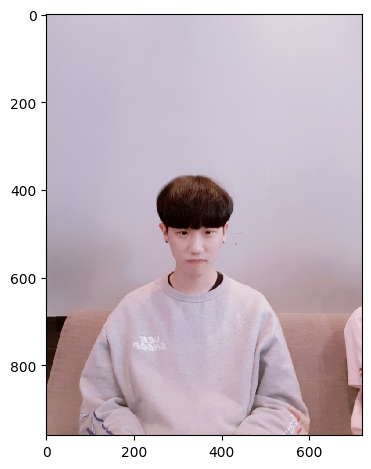

In [25]:
img = imread('myImage.jpg')
imshow(img)

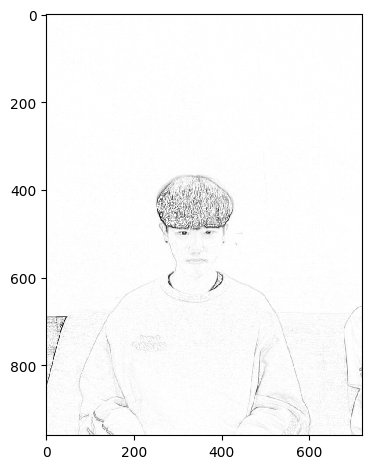

In [26]:
r = sketch(img)
imshow(r)

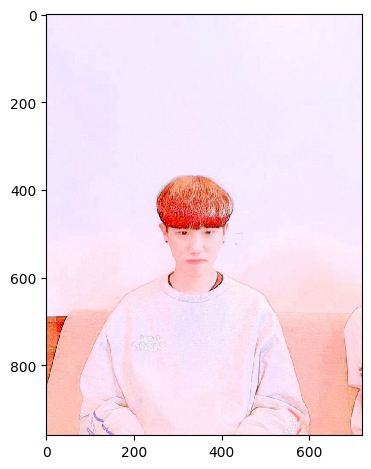

In [27]:
r = painting(img)
imshow(r)